#  1. Linear quadratic regulator
## 1.1 Solving LQR using from Ricatti ODE

In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import cm

In [4]:
class LinearQuadraticRegulator:
    #set up the initial input for the class
    def __init__(self, H, M, C, D, R, T, sigma):
        self.H = torch.tensor(H, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.C = torch.tensor(C, dtype=torch.float32)
        self.D = torch.tensor(D, dtype=torch.float32)
        self.R = torch.tensor(R, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.sigma = torch.tensor(sigma, dtype=torch.float32)

    def riccati_ode(self, t, S):
        # Reshaping S to a 2x2 matrix as it comes in as a flattened array
        S_matrix = torch.tensor(S.reshape(2, 2), dtype=torch.float32)
        DS = -2 * self.H.T @ S_matrix + S_matrix @ self.M @ np.linalg.inv(self.D) @ self.M.T @ S_matrix - self.C      
        # Flattening the derivative to return
        return DS.flatten()

    def solve_riccati_ode(self, time_grid):
        # Solving the ODE backward in time starting from T with terminal condition S(T) = R
        S_T_flat = self.R.flatten()
        time_grid = np.array(time_grid)      
        solution = solve_ivp(self.riccati_ode, [self.T, time_grid[0]], S_T_flat, t_eval=time_grid[::-1], method='DOP853', max_step=0.01)
        # The solution is returned in reverse time, so we reverse it back 
        # Then reshape it 
        S_t = solution.y.T.reshape(time_grid.size, 2, 2)[::-1]
        S_t = torch.tensor(S_t.copy(), dtype=torch.float32)
        return S_t

    
    def value_function(self, t_batch, x_batch):
        #Calculate the value
        N = 10
        I = len(t_batch)
        v = torch.zeros(I)
        
        for i in range(I):
            integ = 0         
            time_grid_k = torch.linspace(t_batch[i], self.T, N, dtype=torch.float32)
            S_tk = self.solve_riccati_ode(time_grid_k)
            #use the small time inverval as ds to calculate the integration
            for j in range(0,N-1):
                integ += np.trace(self.sigma @ self.sigma.T @ S_tk[j]) * (self.T - t_batch[i])/(N-1)
            v[i] = x_batch[i].T @ S_tk[0] @ x_batch[i] + integ
        return v

    def optimal_control(self, t_batch, x_batch):
        
        sorted_indices = torch.argsort(t_batch)
        
        sorted_t_batch = t_batch[sorted_indices]
        sorted_x_batch = x_batch[sorted_indices]
        
        # Interpolate S(t) for each t in t_batch and calculate the optimal control
        S_t = self.solve_riccati_ode(sorted_t_batch)

        if len(x_batch.shape) > 3: 
            S_t = S_t.unsqueeze(1).repeat(1, x_batch.shape[1], 1, 1)  
        
        alpha = -torch.inverse(self.D) @ self.M.T @ S_t @ x_batch
            
        original_order_alpha = alpha[sorted_indices.argsort()]

        return original_order_alpha

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings

warnings.filterwarnings("ignore")

In [6]:
# Problem constants for SDE: dX = (LX + M\alpha)dt + \sigma dW
H = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 0.1 
M = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
sigma = torch.tensor([[0.001],[0.001]], dtype=torch.float32)

# Running reward is x^T C x + a^T D a
C = torch.tensor([[0.0, 0.0], [0.0, 0.0]])
D = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) 

# Terminal reward is x^T R x
R = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 10
T = torch.tensor(1.0, dtype=torch.float32)


x = torch.tensor([[[1],[2]]], dtype=torch.float32)
t_batch= torch.linspace(0.1,0.9, 9)


lqr = LinearQuadraticRegulator(H, M, C, D, R, T, sigma)

## 1.2 LQR MC checks

#### With number of Conte Carlo samples large vary the number of time steps in your simulation

In [7]:
Ns = [1, 10, 50, 100, 500, 1000, 5000]
numPaths = 10**5
k = 0

Js_N = []
vs_N = []    

for N in Ns:
    
    tau = torch.tensor([T/N], dtype=torch.float32)
    t_k = torch.tensor([k*tau], dtype=torch.float32)
    numSteps = N - k

    time_grid = torch.linspace(k, T, numSteps+1, dtype=torch.float32)
    S = lqr.solve_riccati_ode(time_grid)

    X = torch.zeros(numSteps+1, numPaths, 2, 1, dtype=torch.float32)   
    X[0,:] = x

    for t_step in range(numSteps):
        Z = np.random.normal(0, 1, numPaths)
        X[t_step+1] = X[t_step] + tau * (H @ X[t_step] - M @ torch.inverse(D) @ M.T @ S[t_step] @ X[t_step]) \
        + (sigma * torch.sqrt(tau) * Z).T.unsqueeze(2)
    x_batch = X


    a = lqr.optimal_control(time_grid, x_batch)


    # min J on tk:
    f_g = torch.zeros(numPaths, 1)
    integ = torch.zeros(numPaths, 1)
    # calculate integrals without the last one 
    for s in range(k, numSteps):
        integ += ((X[s].transpose(1, 2) @ C @ X[s] + a[s].transpose(1, 2) @ D @ a[s]) * tau).squeeze(2)

    f_g = integ + (X[-1].transpose(1, 2) @ R @ X[-1]).squeeze(2)

    
    J = torch.mean(f_g)
    Js_N.append(J)
    

    v = lqr.value_function(t_k, x)
    vs_N.append(v)

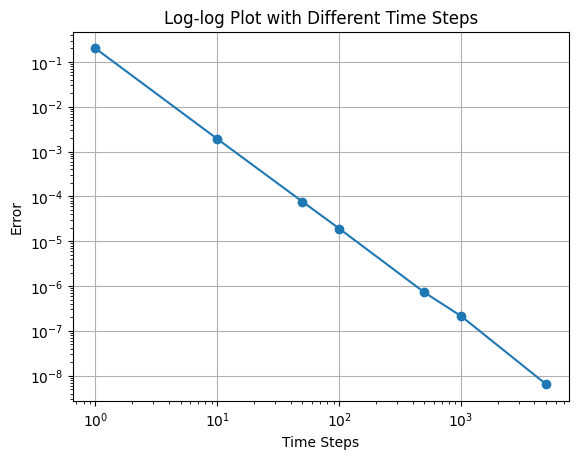

In [8]:
error = [(Js_N[i] - vs_N[i])**2 for i in range(len(Ns))]
error_N = [value.item() for value in error]

# Creating a log-log graph
plt.figure()
plt.loglog(Ns, error_N, marker='o')

plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.title('Log-log Plot with Different Time Steps')

plt.grid(True)
plt.show()

#### With a number of time steps large vary the number of Monte-Carlo samples

In [9]:
N = 5000
Ps = [10, 50, 10**2, 5 * 10**2, 10**3, 5 * 10**3, 10**4, 5 * 10**4, 10**5]
k = 0

Js_P = []
vs_P = []    

for numPaths in Ps:
    
    tau = torch.tensor([T/N], dtype=torch.float32)
    t_k = torch.tensor([k*tau], dtype=torch.float32)
    numSteps = N - k

    time_grid = torch.linspace(k, T, numSteps+1, dtype=torch.float32)
    S = lqr.solve_riccati_ode(time_grid)


    X = torch.zeros(numSteps+1, numPaths, 2, 1, dtype=torch.float32)
    
    X[0,:] = x

    for t_step in range(numSteps):
        Z = np.random.normal(0, 1, numPaths)
        X[t_step+1] = X[t_step] + tau * (H @ X[t_step] - M @ torch.inverse(D) @ M.T @ S[t_step] @ X[t_step]) \
        + (sigma * torch.sqrt(tau) * Z).T.unsqueeze(2)
    x_batch = X


    a = lqr.optimal_control(time_grid, x_batch)


    # min J on tk:
    f_g = torch.zeros(numPaths, 1)
    integ = torch.zeros(numPaths, 1)
    # calculate integrals without the last one 
    for s in range(k, numSteps):
        integ += ((X[s].transpose(1, 2) @ C @ X[s] + a[s].transpose(1, 2) @ D @ a[s]) * tau).squeeze(2)

    f_g = integ + (X[-1].transpose(1, 2) @ R @ X[-1]).squeeze(2)

    J = torch.mean(f_g)
    Js_P.append(J)
    

    v = lqr.value_function(t_k, x)
    vs_P.append(v)

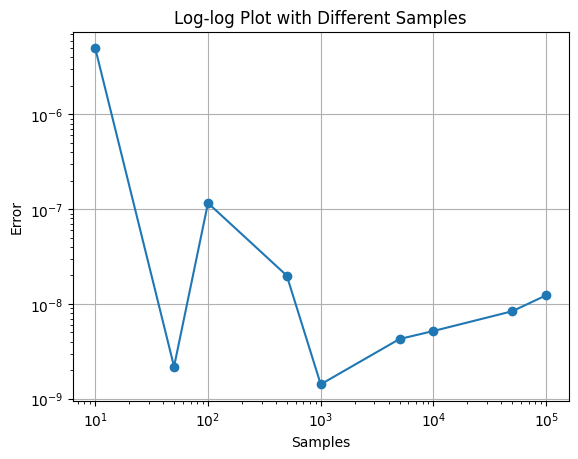

In [10]:
error = [(Js_P[i] - vs_P[i])**2 for i in range(len(Ps))]
error_P = [value.item() for value in error]

# Creating a log-log graph
plt.figure()
plt.loglog(Ps, error_P, marker='o')

plt.xlabel('Samples')
plt.ylabel('Error')
plt.title('Log-log Plot with Different Samples')

plt.grid(True)
plt.show()

# 2. Supervised learning, checking the NNs are good enough
## 2.1 Supervised learning of value function v

In [11]:
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt

#set up the DGM_Layer neural network from the first link provided
class DGM_Layer(nn.Module):
    
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()
        
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            

        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    
    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)
        
        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)
        
        output = ((1-G))*H + Z*S
        return output

class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)

        self.output_layer = nn.Linear(dim_S, 1)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

In [12]:
# Generate synthetic train data
# Generate N samples where t ~ UNIF(0,1) & x1 and x2 ~ UNIF(-3,3)

def generate_training_data(N, T):
    t_data = np.random.uniform(0, T, N)
    x_data = np.random.uniform(-3, 3, (N, 2))
    return torch.tensor(t_data, dtype=torch.float32), torch.tensor(x_data, dtype=torch.float32)


In [16]:
# Init LQR object
lqr1 = LinearQuadraticRegulator(H, M, C, D, R, T, sigma)

# Create NN
nn1 = Net_DGM(2, 100)

# Define optimiser
optimiser = optim.Adam(nn1.parameters(), lr=0.01)

# Loss f
lossf = nn.MSELoss()

# Training parameters
num_epochs = 200
N = 10


In [17]:
losses = []
for epoch in range(num_epochs):
    #simulate the training data for both t and x
    t_train, x_train = generate_training_data(N, T)
    outputs = nn1(t_train.unsqueeze(1), x_train)
    #get the true value
    true_values = lqr1.value_function(t_train, x_train.unsqueeze(-1))
    
    optimiser.zero_grad()
    loss = lossf(outputs.squeeze(1), true_values)

    # Backward pass and optimization

    loss.backward()
    optimiser.step()

    losses.append(loss.item())

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            

Epoch [5/200], Loss: 116.6250
Epoch [10/200], Loss: 648.3080
Epoch [15/200], Loss: 466.3515
Epoch [20/200], Loss: 44.6429
Epoch [25/200], Loss: 53.3266
Epoch [30/200], Loss: 564.2064
Epoch [35/200], Loss: 70.8540
Epoch [40/200], Loss: 487.8870
Epoch [45/200], Loss: 226.4807
Epoch [50/200], Loss: 154.4786
Epoch [55/200], Loss: 18.9954
Epoch [60/200], Loss: 327.9576
Epoch [65/200], Loss: 2.2755
Epoch [70/200], Loss: 74.1825
Epoch [75/200], Loss: 112.2844
Epoch [80/200], Loss: 54.7357
Epoch [85/200], Loss: 63.6184
Epoch [90/200], Loss: 641.9111
Epoch [95/200], Loss: 60.9502
Epoch [100/200], Loss: 78.3997
Epoch [105/200], Loss: 88.0906
Epoch [110/200], Loss: 33.8211
Epoch [115/200], Loss: 11.6243
Epoch [120/200], Loss: 98.2756
Epoch [125/200], Loss: 27.6771
Epoch [130/200], Loss: 91.0348
Epoch [135/200], Loss: 125.3621
Epoch [140/200], Loss: 13.5908
Epoch [145/200], Loss: 10.5808
Epoch [150/200], Loss: 54.7885
Epoch [155/200], Loss: 20.3608
Epoch [160/200], Loss: 190.7188
Epoch [165/200], 

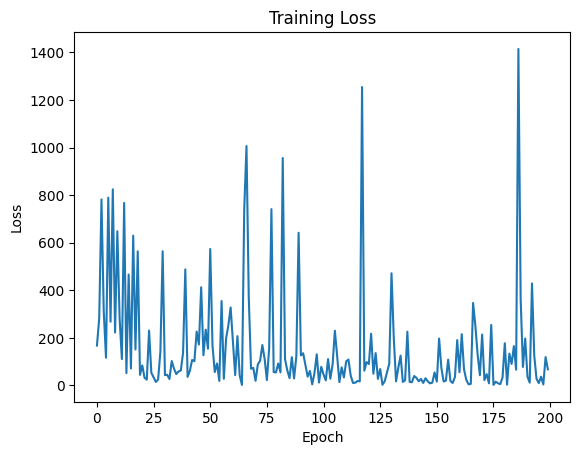

In [18]:
# Plot training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


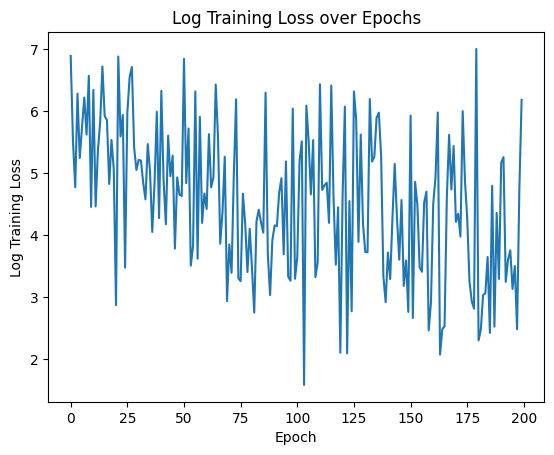

In [315]:
import numpy as np

# Plot the log of the training losses
plt.plot(np.log(losses))
plt.xlabel('Epoch')
plt.ylabel('Log Training Loss')
plt.title('Log Training Loss over Epochs')
plt.show()


## 2.2 Supervised learning of Markov control a

In [19]:
import torch
import torch.nn as nn
from collections import namedtuple
from typing import Tuple
#The FFN neural net work is defined in the github link 
class FFN(nn.Module):
    
    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x)


In [13]:
# Define the loss function
lossf = nn.MSELoss()

#we have 3 inputs, 2 hidden layers and in each layer we have 100 nodes, output is 2
sizes = [3,100,100,2]

nn2 = FFN(sizes)

num_epochs = 1000
N2 = 200 
# optimiser still the same
optimiser = optim.Adam(nn2.parameters(), lr=0.001)


In [43]:
# Initialize a list to store loss values for each epoch
losses2 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    #generate training data: time points (t) and states (x)
    t_train, x_train = generate_training_data(N2, T)
    # lqr1.optimal_control can not take t_batch with repeat values
    while torch.unique(t_train).shape[0] != N2:
        t_train , _ = generate_training_data(N2, T)
    
    #pass concatenated time and state inputs through the neural network to get estimated control value
    outputs = nn2(torch.cat((t_train.unsqueeze(1), x_train), dim=1))
    true_values2 = lqr1.optimal_control(t_train, x_train.unsqueeze(-1))
    
    #reset gradients before performing backward pass
    optimiser.zero_grad()
    #compute the loss between estimated control value and optimal control value
    loss = lossf(outputs.unsqueeze(-1), true_values2)
    
    # Backward pass and optimization
    loss.backward()
    optimiser.step()
    
    #record the training loss
    losses2.append(loss.item())

    if (epoch + 1.) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 29.6467
Epoch [200/1000], Loss: 27.9922
Epoch [300/1000], Loss: 24.4647
Epoch [400/1000], Loss: 27.5276
Epoch [500/1000], Loss: 23.8318
Epoch [600/1000], Loss: 31.0226
Epoch [700/1000], Loss: 34.1896
Epoch [800/1000], Loss: 31.6119
Epoch [900/1000], Loss: 28.4203
Epoch [1000/1000], Loss: 28.0428


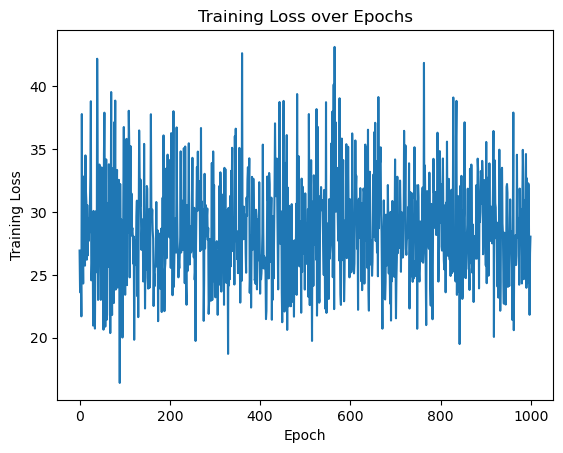

In [44]:
# Plot the training loss
plt.plot(losses2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

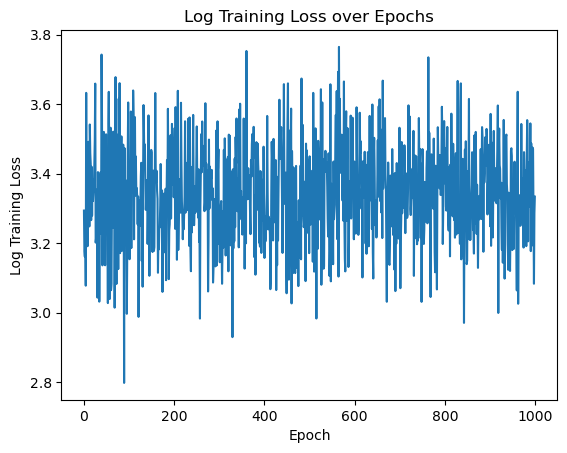

In [45]:
# Plot the log of the training losses
plt.plot(np.log(losses2))
plt.xlabel('Epoch')
plt.ylabel('Log Training Loss')
plt.title('Log Training Loss over Epochs')
plt.show()


# 3 & 4
# 3. Deep Galerkin approximation for a linear PDE

In [22]:
class Net(nn.Module):
    # n_layer: the number of hidden layers
    # n_hidden: the number of vertices in each layer
    def __init__(self, n_layer, n_hidden, dim):
        super(Net, self).__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        o = self.act(self.input_layer(x))

        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))
        
        out = self.output_layer(o)
        
        return out

    def act(self, x):
        return x * torch.sigmoid(x)
        # return torch.sigmoid(x)
         #return torch.tanh(x)
        # return torch.relu(x)

In [23]:
class Net_a(nn.Module):
    # n_layer: the number of hidden layers
    # n_hidden: the number of vertices in each layer
    def __init__(self, n_layer, n_hidden, dim):
        super(Net_a, self).__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, 2)
        
    def forward(self, x):
        o = self.act(self.input_layer(x))

        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))
        
        out = self.output_layer(o)
        
        return out

    def act(self, x):
        return x * torch.sigmoid(x)

In [24]:
class LinearPDESolver():
    def __init__(self, net, T, H, M, C, D, R, sigma, alpha):
        self.net = net
        self.T = T
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.alpha = alpha

    def compute_residuals(self, x):
        # Make sure that x requires gradient
        x.requires_grad = True
        
        # Predict the function value using the neural network
        a = self.alpha
        if type(self.alpha) == Net_a:
            a = self.alpha(x).unsqueeze(-1)
        u = self.net(x)
        
        # Compute the gradients of u with respect to x
        grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        du_dt = grads[:, 0].unsqueeze(-1) 
        du_dx = grads[:, 1:].unsqueeze(2)

        
        # Calculate second-order derivatives
        d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0][:, 1:].unsqueeze(2)
        
        
        # The PDE residual
        pde_residual = du_dt + 0.5 * torch.diagonal(sigma @ sigma.T @ d2u_dx2, dim1=1, dim2=2) + \
            (du_dx.transpose(1, 2) @ self.H @ x[:, 1:].unsqueeze(2)).squeeze(1) + \
            (du_dx.transpose(1, 2) @ self.M @ a).squeeze(1) + \
            (x[:, 1:].unsqueeze(1) @ self.C @ x[:, 1:].unsqueeze(2)).squeeze(1) + \
            (a.transpose(-1,-2) @ self.D @ a).squeeze(1)  # Ensure it's a scalarz
        

        
        # Boundary condition residual
        boundary_condition = u - (x[:, 1:].unsqueeze(1) @ self.R @ x[:, 1:].unsqueeze(2)).squeeze(1)
             
        
        # The combined loss
        loss = torch.mean(pde_residual ** 2) + torch.mean(boundary_condition ** 2)
        return loss

    def sample(self, batch_size):
        
        t = torch.rand(batch_size, 1) * self.T
        x_space = torch.FloatTensor(batch_size, 2).uniform_(-3, 3)  # Assuming the spatial domain is [0,1] for both x and y
        return torch.cat([t, x_space], dim=1)

    def train(self, optimizer, epochs, batch_size):
        Epoch, Loss = [],[]
        for epoch in range(epochs):
            x_batch = self.sample(batch_size)
            optimizer.step()
            loss = self.compute_residuals(x_batch)
            
            optimizer.zero_grad()
            loss.backward()

            
            Epoch.append(epoch)
            Loss.append(loss.item())
            if epoch % 200 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
        return Epoch, Loss
                

In [25]:
class LinearPDESolver_a():
    def __init__(self, net_a, T, H, M, C, D, R, sigma, net_v):
        self.net_a = net_a
        self.T = T
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.net_v = net_v

    def compute_residuals(self, x):
        # Make sure that x requires gradient
        x.requires_grad = True
        
        # Predict the function value using the neural network
        a = self.net_a(x).unsqueeze(-1)

        v = self.net_v(x)
        
        # Compute the gradients of v with respect to x
        grads = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        dv_dx = grads[:, 1:].unsqueeze(2)

        
        # The PDE residual
        hamiltonian =  (dv_dx.transpose(1, 2) @ self.H @ x[:, 1:].unsqueeze(2)).squeeze(1) + \
            (dv_dx.transpose(1, 2) @ self.M @ a).squeeze(1) + \
            (x[:, 1:].unsqueeze(1) @ self.C @ x[:, 1:].unsqueeze(2)).squeeze(1) + \
            a.transpose(1, 2) @ self.D @ a  # Ensure it's a scalarz          
        
        # The combined loss
        loss = torch.mean(hamiltonian)
        return loss

    def sample(self, batch_size):
        
        t = torch.rand(batch_size, 1) * self.T
        x_space = torch.FloatTensor(batch_size, 2).uniform_(-3, 3)  # Assuming the spatial domain is [0,1] for both x and y
        return torch.cat([t, x_space], dim=1)

    def train(self, optimizer, epochs, batch_size):
        Epoch, Loss = [],[]
        for epoch in range(epochs):
            x_batch = self.sample(batch_size)
            
            optimizer.zero_grad()
            loss = self.compute_residuals(x_batch)
            
            
            loss.backward()
            optimizer.step()
            
#             Epoch.append(epoch)
#             Loss.append(loss.item())
#             if epoch % 100 == 0:
#                 print(f'Epoch {epoch}, Loss: {loss.item()}')
#         return Epoch, Loss
                

In [26]:
# Define constants for the PDE based on the exercise description
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32).view(-1, 1)

# Initialize network
net = Net(n_layer=8, n_hidden=100, dim=3)  # t, x1, and x2


# Initialize solver
solver = LinearPDESolver(net, T, H, M, C, D, R, sigma, alpha)

# Set up the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Train the model
# Epoch, Loss = 
Epoch, Loss = solver.train(optimizer, epochs=1000, batch_size=800)

Epoch 0, Loss: 4772.81640625
Epoch 200, Loss: 170.2110595703125
Epoch 400, Loss: 150.31060791015625
Epoch 600, Loss: 137.00634765625
Epoch 800, Loss: 148.7141876220703


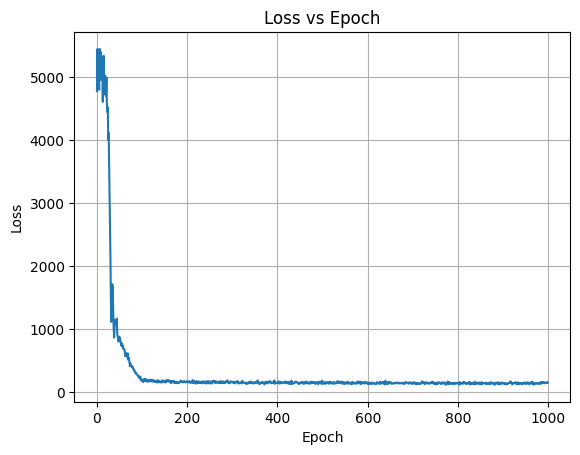

In [27]:
# Data for plotting
fig, ax = plt.subplots()
ax.plot(Epoch, Loss)
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Loss vs Epoch')
ax.grid()
plt.show()

In [ ]:
test_size = 100
x_test = solver.sample(test_size)

# Calculate Monte Carlo solution with test batch of t, x
# with constants a
a = torch.tensor([[1],[1]], dtype=torch.float32)
numSteps = 500
numPaths = 1000

X_test = x_test[:, 1:].unsqueeze(2)


J_const = []
for i in range(test_size):

    
    tau = torch.tensor([T/numSteps], dtype=torch.float32)
    t_k = torch.tensor([0], dtype=torch.float32)
    time_grid = torch.linspace(0, T, numSteps+1, dtype=torch.float32)
    S = lqr.solve_riccati_ode(time_grid)

    X = torch.zeros(numSteps+1, numPaths, 2, 1, dtype=torch.float32)    
    X[0,:] = X_test[i]
    for t_step in range(numSteps):
        Z = np.random.normal(0, 1, numPaths)
        X[t_step+1] = X[t_step] + tau * (H @ X[t_step] + M @ a) + (sigma * torch.sqrt(tau) * Z).T.unsqueeze(2)
    x_batch = X


    # min J on tk:
    f_g = torch.zeros(numPaths, 1)
    # for p in range(numPaths):
    integ = torch.zeros(numPaths, 1)
    # calculate integrals without the last one 
    for s in range(0, numSteps):
        integ += ((X[s].transpose(1, 2) @ C @ X[s] + a.T @ D @ a) * tau).squeeze(2)

    f_g = integ + (X[-1].transpose(1, 2) @ R @ X[-1]).squeeze(2)

    J = torch.mean(f_g)
    J_const.append(J)

In [ ]:
error = (torch.tensor(J_const, dtype=torch.float32).unsqueeze(-1) - net(x_test))**2

error_DG_MC = error.detach().numpy()

# Creating a line graph
plt.figure()
plt.plot(error_DG_MC)


# plt.loglog(error_DG_MC, marker='o')

plt.xlabel('Samples t, x')
plt.ylabel('Error')
plt.title('Deep Galerkin Error Against the Monte Carlo Solution')

plt.grid(True)
plt.show()

# 4. Policy iteration with DGM

In [ ]:
test_size = 300
x_test = solver.sample(test_size)
# x_test = x_test1
epochs = 1000
batch_size = 200

v0 = torch.tensor([[-999.]], dtype=torch.float32).repeat(test_size,1)
net.eval()
v1 = net(x_test)

Vs = [v1]

count = 0
while torch.mean((v0 - net(x_test))**2) > 1:
    v0 = net(x_test)
    
    #a_i
    net_a = Net_a(n_layer=3, n_hidden=64, dim=3)  # t, x1, and x2
    solver_a = LinearPDESolver_a(net_a, T, H, M, C, D, R, sigma, net)
    optimizer_a = torch.optim.Adam(net_a.parameters(), lr=0.001)
    solver_a.train(optimizer_a, epochs, batch_size)

    net_a.eval()
    
    #v_i
    net = Net(n_layer=3, n_hidden=50, dim=3)  # t, x1, and x2
    solver = LinearPDESolver(net, T, H, M, C, D, R, sigma, net_a)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    Epoch, Loss = solver.train(optimizer, epochs, batch_size)

    net.eval()
    
    v1 = net(x_test)
    Vs.append(v1)
    
    count +=1
    if count % 10 == 9:
        print(f'Iteration {count}, Difference(MSE): {torch.mean((v0 - net(x_test))**2)}')